In [1]:
!pip install vit-keras

In [2]:
from vit_keras import vit, utils, visualize
import tensorflow as tf
import tensorflow_datasets as tfds

from keras.utils.layer_utils import count_params

import numpy as np
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt

from random import randint
import warnings
warnings.filterwarnings("ignore") 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
DATA_DIR = "/kaggle/working"
IMAGE_SIZE = 64
BATCH_SIZE = 16
NUM_CLASSES = 10
AUTO = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER = 27000 # == int(ds_info.splits['train'].num_examples * 0.7)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete9K1B6Q/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


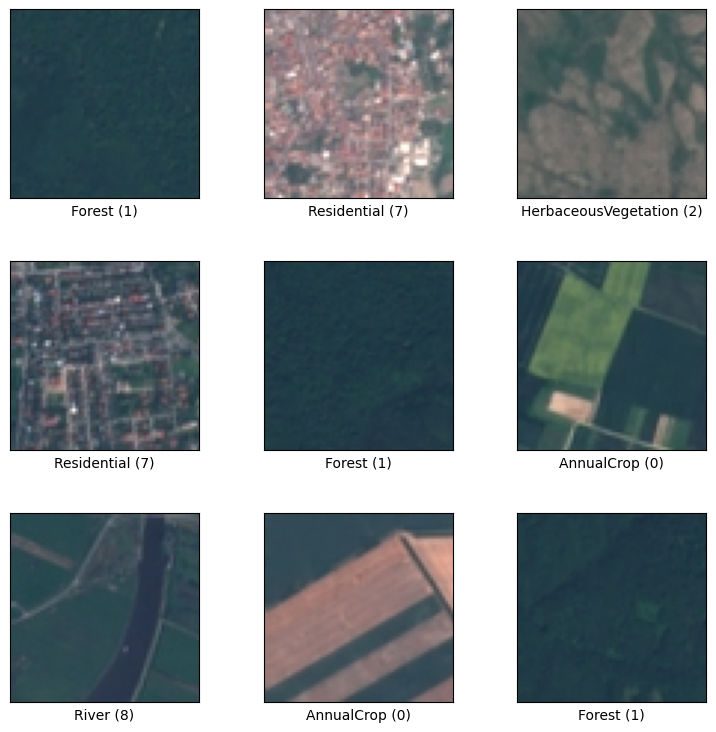

In [4]:
(ds_train, ds_valid), ds_info = tfds.load( 'eurosat',
                                            split=['train[:70%]', 'train[70%:]'],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True,
                                         )
tfds.show_examples(ds_train, ds_info);

In [5]:
ds_info.features["label"].num_classes

10

In [6]:
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

ds_train = (ds_train
            .map(preprocess, AUTO)
            .cache()
            .shuffle(SHUFFLE_BUFFER)
            .repeat()
            # Augmentations go here .map(augment, AUTO)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(AUTO))

ds_valid = (ds_valid
            .map(preprocess, AUTO)
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

In [7]:
batch, label = iter(ds_train.take(1)).next()

In [8]:
type(batch), batch.shape, batch.dtype

(tensorflow.python.framework.ops.EagerTensor,
 TensorShape([16, 64, 64, 3]),
 tf.float32)

In [9]:
def get_model(image_size, include_top=True):
    return vit.vit_b16(
        image_size=image_size,
        activation='sigmoid',
        pretrained=True,
        include_top=include_top,
        pretrained_top = include_top
    )

### without finetuning

In [10]:
model = get_model(IMAGE_SIZE)
model.summary()

347502902/347502902 [==============================] - 5s 0us/step
Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 embedding (Conv2D)          (None, 4, 4, 768)         590592    
                                                                 
 reshape (Reshape)           (None, 16, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 17, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 17, 768)          13056     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 17, 768),        708

1/1 [==============================] - 8s 8s/step
matchstick


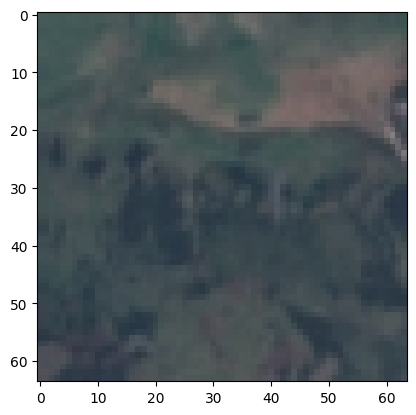

In [11]:
image = batch[0].numpy()
classes = utils.get_imagenet_classes()
X = vit.preprocess_inputs(image).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
y = model.predict(X)
print(classes[y[0].argmax()])
image = batch[0].numpy()
plt.imshow(image)

Since the model is trained on imagenet dataset its prediction are completely wring as the model haven't seen these classes

In [12]:
layer = model.get_layer('embedding')
type(layer.weights), len(layer.weights), type(layer.weights[0])

(list, 2, tensorflow.python.ops.resource_variable_ops.ResourceVariable)

In [13]:
weight = layer.weights[0]
type(weight), weight.shape

(tensorflow.python.ops.resource_variable_ops.ResourceVariable,
 TensorShape([16, 16, 3, 768]))

filters of embedding layer


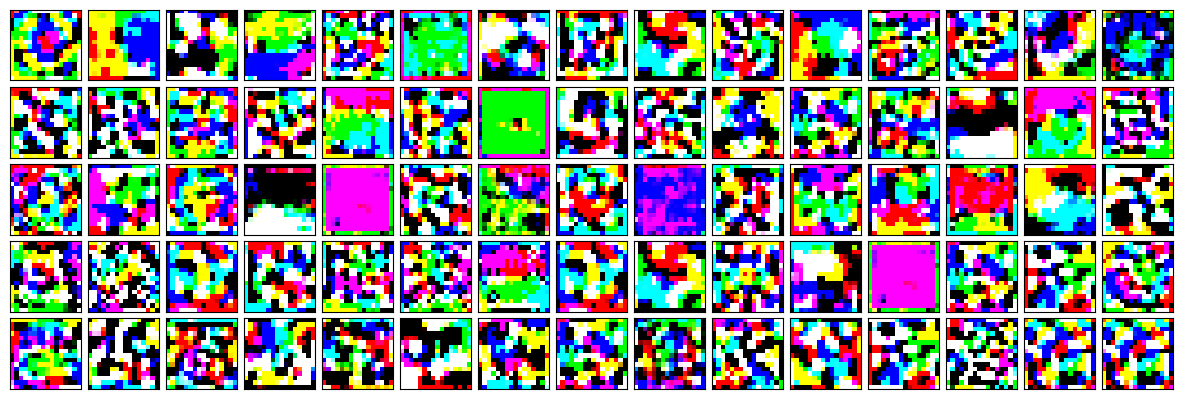

In [14]:
#2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384
x = 5
y = 15
fig = plt.figure(figsize=(y, x), constrained_layout=False)
grid_spec = fig.add_gridspec(x, y, wspace=0.1, hspace=0.01) #create a grid spec
axs = grid_spec.subplots() #get all the subplots in this gridspec
for (i, j), ax in np.ndenumerate(axs): #enumerating in these axes (0, 1), (0,2) ... (1, 0), (1, 1) ...
    ax.set(xticks=[], yticks=[])
    ax.imshow(weight.numpy()[:, :, :, y*i+j+randint(0, 767-(y*i+j))]*255)
fig.show()
# fig.suptitle(f'filters of {layer}');
print(f'filters of {layer.name} layer')

these filters are the filters for the first layer of convolutional layer

In [15]:
# layer = model.get_layer('Transformer/encoderblock_2')
# type(layer.weights), len(layer.weights), type(layer.weights[0])

### training top layer

* training only top layer to get 10 class classifier as per our need

In [16]:
base_model = get_model(image_size=IMAGE_SIZE, include_top=False)
base_model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 embedding (Conv2D)          (None, 4, 4, 768)         590592    
                                                                 
 reshape_1 (Reshape)         (None, 16, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 17, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 17, 768)          13056     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 17, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [17]:
classifier = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Dense(units=64, activation='gelu'),
        tf.keras.layers.Dropout(rate=0.4),
        tf.keras.layers.Dense(units=NUM_CLASSES, activation='gelu')],
    name = 'classifier')

In [18]:
model = tf.keras.Sequential(
    layers = [
        base_model,
        classifier],
    name='vit-b16_custom')
model.summary()

Model: "vit-b16_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85660416  
                                                                 
 classifier (Sequential)     (None, 10)                49866     
                                                                 
Total params: 85,710,282
Trainable params: 85,710,282
Non-trainable params: 0
_________________________________________________________________


In [19]:
#freeze the base model
model.get_layer('vit-b16').trainable = False

#total trainable params -> only classifiers params
count_params(model.trainable_weights)

49866

In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [21]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=4,
    verbose=1,
    mode='auto',
    min_delta=0.001,
    cooldown=2,
    min_lr=0.00001,
)

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
    patience = 15, 
    restore_best_weights = True, 
    verbose = 1
)

In [22]:
EPOCHS = 10
STEPS_PER_EPOCH = int(ds_info.splits['train'].num_examples * 0.7) // BATCH_SIZE

history = model.fit(ds_train,
                    validation_data=ds_valid, 
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    callbacks = [lr_scheduler, early_stopping_callbacks],
                   )

Epoch 1/10
1181/1181 [==============================] - 50s 35ms/step - loss: 3.2427 - sparse_categorical_accuracy: 0.2716 - val_loss: 2.0035 - val_sparse_categorical_accuracy: 0.4181 - lr: 0.0010
Epoch 2/10
1181/1181 [==============================] - 36s 30ms/step - loss: 2.3242 - sparse_categorical_accuracy: 0.3086 - val_loss: 2.0193 - val_sparse_categorical_accuracy: 0.4086 - lr: 0.0010
Epoch 3/10
1181/1181 [==============================] - 40s 34ms/step - loss: 2.3693 - sparse_categorical_accuracy: 0.3546 - val_loss: 2.1556 - val_sparse_categorical_accuracy: 0.4017 - lr: 0.0010
Epoch 4/10
1181/1181 [==============================] - 35s 30ms/step - loss: 2.3953 - sparse_categorical_accuracy: 0.2802 - val_loss: 2.2826 - val_sparse_categorical_accuracy: 0.2601 - lr: 0.0010
Epoch 5/10
1178/1181 [============================>.] - ETA: 0s - loss: 2.4122 - sparse_categorical_accuracy: 0.3153
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
1181/1181 [========

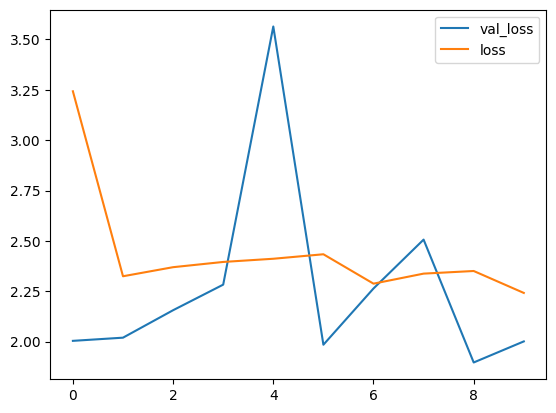

In [24]:
history = history.history
plt.plot(history['val_loss'], label='val_loss')
plt.plot(history['loss'], label='loss')
plt.legend()
plt.show()

In [ ]:
idx = 30%BATCH_SIZE
image = batch[idx].numpy()
classes = utils.get_imagenet_classes()
X = vit.preprocess_inputs(image).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
y = model.predict(X)
image = batch[idx].numpy()
print(ds_info.features['label'].int2str(y.argmax()))
plt.imshow(image)

now the results are closed and belong to one of our classes after finetuning the classifier layers

filters of embedding layer


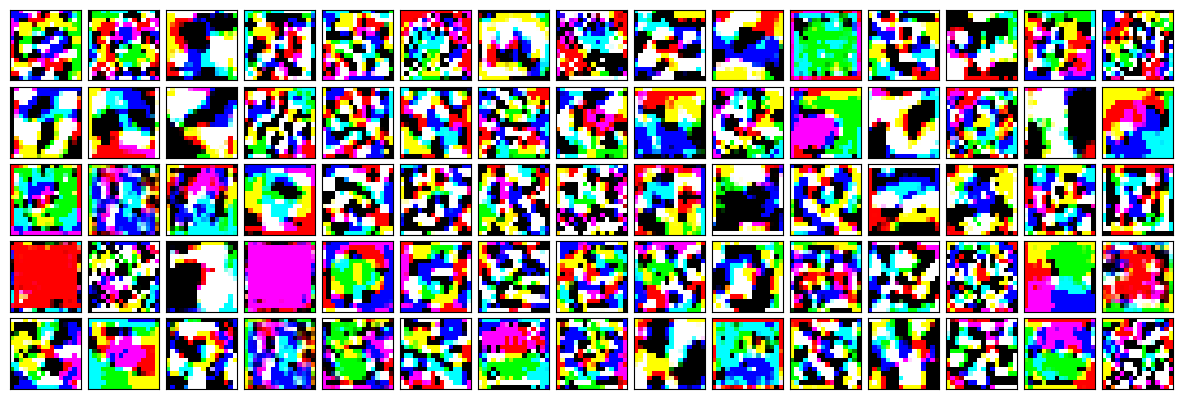

In [25]:
x = 5
y = 15
fig = plt.figure(figsize=(y, x), constrained_layout=False)
grid_spec = fig.add_gridspec(x, y, wspace=0.1, hspace=0.01) #create a grid spec
axs = grid_spec.subplots() #get all the subplots in this gridspec
for (i, j), ax in np.ndenumerate(axs): #enumerating in these axes (0, 1), (0,2) ... (1, 0), (1, 1) ...
    ax.set(xticks=[], yticks=[])
    ax.imshow(weight.numpy()[:, :, :, y*i+j+randint(0, 767-(y*i+j))]*255)
fig.show()
# fig.suptitle(f'filters of {layer}');
print(f'filters of {layer.name} layer')

### Now, Finetuning Base Layers

In [26]:
model = tf.keras.models.clone_model(model)

In [27]:
model.summary()

Model: "vit-b16_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85660416  
                                                                 
 classifier (Sequential)     (None, 10)                49866     
                                                                 
Total params: 85,710,282
Trainable params: 49,866
Non-trainable params: 85,660,416
_________________________________________________________________


In [28]:
#unfreeze the base layer
model.get_layer('vit-b16').trainable = True

#freeze the top layer
model.get_layer('classifier').trainable = False

#total trainable params -> only classifiers params
count_params(model.trainable_weights)

85660416

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), #low learning rate for finetuning
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [30]:

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=4,
    verbose=1,
    mode='auto',
    min_delta=0.001,
    cooldown=2,
    min_lr=0.00001,
)

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
    patience = 15, 
    restore_best_weights = True, 
    verbose = 1
)

In [31]:
EPOCHS = 30
STEPS_PER_EPOCH = int(ds_info.splits['train'].num_examples) // BATCH_SIZE

history = model.fit(ds_train,
                    validation_data=ds_valid, 
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    callbacks = [lr_scheduler, early_stopping_callbacks],
                   )

Epoch 1/30
1687/1687 [==============================] - 143s 61ms/step - loss: 5.0523 - sparse_categorical_accuracy: 0.0953 - val_loss: 2.5931 - val_sparse_categorical_accuracy: 0.0919 - lr: 1.0000e-04
Epoch 2/30
1687/1687 [==============================] - 103s 61ms/step - loss: 4.1813 - sparse_categorical_accuracy: 0.0978 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1058 - lr: 1.0000e-04
Epoch 3/30
1687/1687 [==============================] - 100s 60ms/step - loss: 3.6212 - sparse_categorical_accuracy: 0.0942 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1058 - lr: 1.0000e-04
Epoch 4/30
1687/1687 [==============================] - 105s 62ms/step - loss: 3.6313 - sparse_categorical_accuracy: 0.0951 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0965 - lr: 1.0000e-04
Epoch 5/30
1687/1687 [==============================] - 105s 62ms/step - loss: 3.4499 - sparse_categorical_accuracy: 0.0941 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0965 - lr: 1

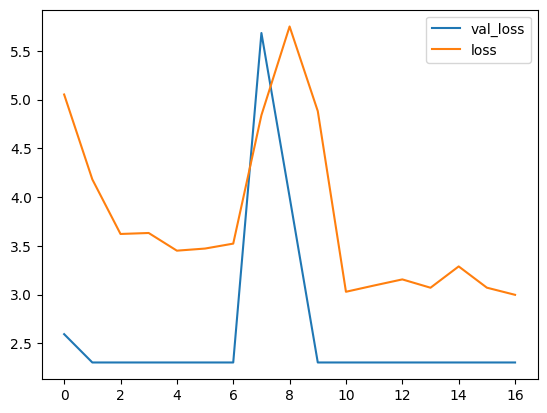

In [32]:
history = history.history
plt.plot(history['val_loss'], label='val_loss')
plt.plot(history['loss'], label='loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 46ms/step
SeaLake


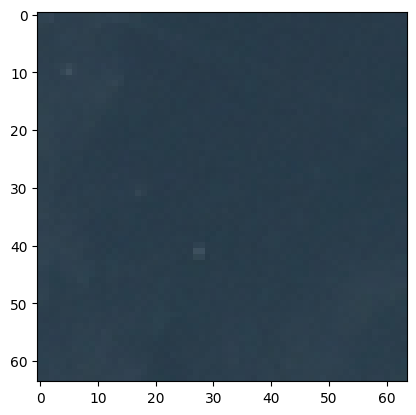

In [39]:
idx = 9%BATCH_SIZE
image = batch[idx].numpy()
classes = utils.get_imagenet_classes()
X = vit.preprocess_inputs(image).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
y = model.predict(X)
image = batch[idx].numpy()
print(ds_info.features['label'].int2str(y.argmax()))
plt.imshow(image)

filters of embedding layer


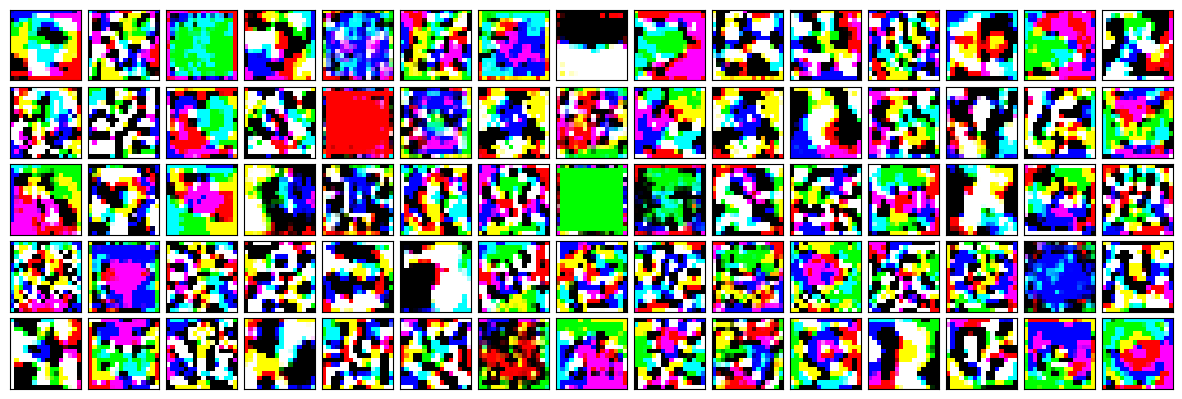

In [34]:
x = 5
y = 15
fig = plt.figure(figsize=(y, x), constrained_layout=False)
grid_spec = fig.add_gridspec(x, y, wspace=0.1, hspace=0.01) #create a grid spec
axs = grid_spec.subplots() #get all the subplots in this gridspec
for (i, j), ax in np.ndenumerate(axs): #enumerating in these axes (0, 1), (0,2) ... (1, 0), (1, 1) ...
    ax.set(xticks=[], yticks=[])
    ax.imshow(weight.numpy()[:, :, :, y*i+j+randint(0, 767-(y*i+j))]*255)
fig.show()
# fig.suptitle(f'filters of {layer}');
print(f'filters of {layer.name} layer')

### Full Finetuning

In [40]:
model = tf.keras.models.clone_model(model)

In [41]:
model.summary()

Model: "vit-b16_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85660416  
                                                                 
 classifier (Sequential)     (None, 10)                49866     
                                                                 
Total params: 85,710,282
Trainable params: 85,660,416
Non-trainable params: 49,866
_________________________________________________________________


In [42]:
#unfreeze the base layer
model.get_layer('vit-b16').trainable = True

#unfreeze the top layer
model.get_layer('classifier').trainable = True

#total trainable params -> only classifiers params
count_params(model.trainable_weights)

85710282

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), #low learning rate for finetuning
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [44]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=4,
    verbose=1,
    mode='auto',
    min_delta=0.001,
    cooldown=2,
    min_lr=0.00001,
)

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
    patience = 15, 
    restore_best_weights = True, 
    verbose = 1
)

In [45]:
EPOCHS = 30
STEPS_PER_EPOCH = int(ds_info.splits['train'].num_examples) // BATCH_SIZE

history = model.fit(ds_train,
                    validation_data=ds_valid, 
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    callbacks = [lr_scheduler, early_stopping_callbacks],
                   )

Epoch 1/30
1687/1687 [==============================] - 142s 61ms/step - loss: 7.5133 - sparse_categorical_accuracy: 0.0984 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1152 - lr: 1.0000e-04
Epoch 2/30
1687/1687 [==============================] - 101s 60ms/step - loss: 3.0989 - sparse_categorical_accuracy: 0.1030 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1152 - lr: 1.0000e-04
Epoch 3/30
1687/1687 [==============================] - 105s 62ms/step - loss: 3.0360 - sparse_categorical_accuracy: 0.1031 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1152 - lr: 1.0000e-04
Epoch 4/30
1687/1687 [==============================] - 105s 62ms/step - loss: 2.8663 - sparse_categorical_accuracy: 0.1023 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1152 - lr: 1.0000e-04
Epoch 5/30
1687/1687 [==============================] - ETA: 0s - loss: 2.7307 - sparse_categorical_accuracy: 0.1034
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.

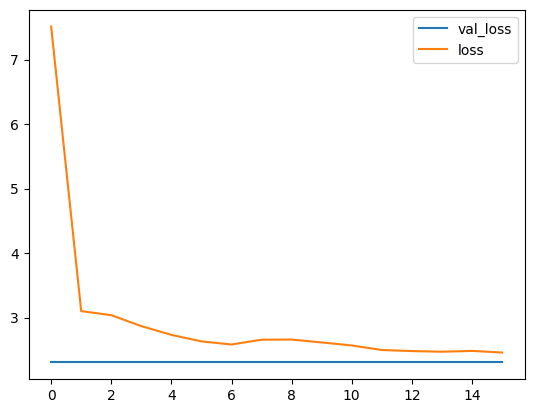

In [46]:
history = history.history
plt.plot(history['val_loss'], label='val_loss')
plt.plot(history['loss'], label='loss')
plt.legend()
plt.show()

1/1 [==============================] - 3s 3s/step
HerbaceousVegetation


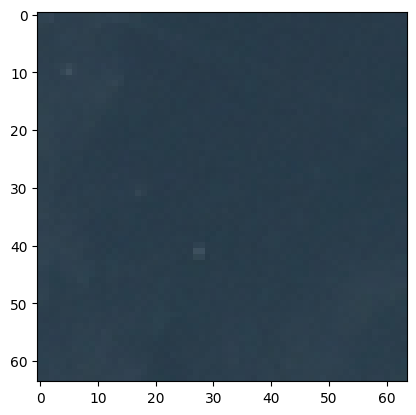

In [47]:
idx = 9%BATCH_SIZE
image = batch[idx].numpy()
classes = utils.get_imagenet_classes()
X = vit.preprocess_inputs(image).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
y = model.predict(X)
image = batch[idx].numpy()
print(ds_info.features['label'].int2str(y.argmax()))
plt.imshow(image)

filters of embedding layer


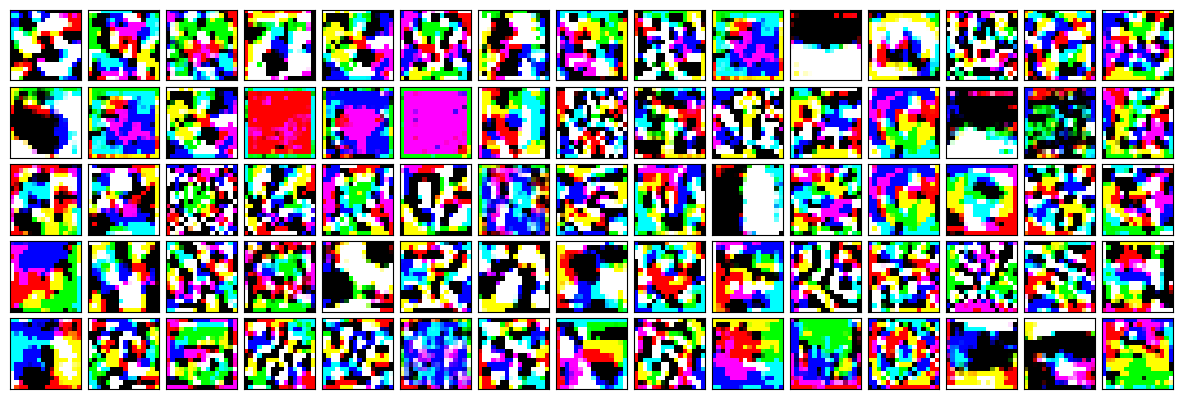

In [48]:
x = 5
y = 15
fig = plt.figure(figsize=(y, x), constrained_layout=False)
grid_spec = fig.add_gridspec(x, y, wspace=0.1, hspace=0.01) #create a grid spec
axs = grid_spec.subplots() #get all the subplots in this gridspec
for (i, j), ax in np.ndenumerate(axs): #enumerating in these axes (0, 1), (0,2) ... (1, 0), (1, 1) ...
    ax.set(xticks=[], yticks=[])
    ax.imshow(weight.numpy()[:, :, :, y*i+j+randint(0, 767-(y*i+j))]*255)
fig.show()
# fig.suptitle(f'filters of {layer}');
print(f'filters of {layer.name} layer')